# Human Non-Speech Sound Classification
[INTRODUCTION TO THE PROBLEM HERE]

### Datasets
[DATASET DESCRIPTION HERE]


### Tasks
[TASK HERE]
- data augmentation techniques: Noise, Reverb, Delay, Low-pass filter 
- baseline models (XGBoost, Logistic regression)

### Integrants:
Name, Matricola, Email respectively
- Santiago Víquez Segura, 2048722, santiago.viquezsegura@studenti.unipd.it
- Ivan Padezhki, 2041499, ivandragomirov.padezhki@studenti.unipd.it

## Dependencies

In [2]:
import os
import shutil
import urllib.request
import zipfile
import glob
import pandas as pd
import numpy as np
import IPython.display
import matplotlib.pyplot as plt
import numpy as np
import wave
import sys
import librosa
import librosa.display
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn import svm
import xgboost as xgb
import time
import seaborn as sns

## Download Dataset

In [3]:
def download_dataset(name):
    """
    Download the dataset into current working directory.
    
    Originally taken from https://nbviewer.org/github/karoldvl/paper-2015-esc-dataset/blob/
    master/Notebook/ESC-Dataset-for-Environmental-Sound-Classification.ipynb#Setup
    Additional modifications were applied to make it work with Python 3
    """
    if not os.path.exists(name):
        os.mkdir(name)
        urllib.request.urlretrieve(f'https://github.com/karoldvl/{name}/archive/master.zip', f'{name}/{name}.zip')

        with zipfile.ZipFile(f'{name}/{name}.zip') as package:
            package.extractall(f'{name}/')

        os.unlink(f'{name}/{name}.zip')        

        for src in glob.glob(f'{name}/{name}-master/*'):
            shutil.move(src, '{0}/{1}'.format(name, os.path.basename(src)))

        shutil.rmtree(f'{name}/{name}-master')

download_dataset('ESC-50')

In [4]:
ls ESC-50

LICENSE           audio/            meta/             requirements.txt
README.md         esc50.gif         pytest.ini        tests/


## Sample Dataset: Non-Speech Human Sounds

In this project we are going to fucus at identifying non-speech human sounds. Such as: `crying_baby`, `sneezing`, `clapping`, etc. So we are going to filter these categories from the main esc50 dataset.

In [5]:
esc50 = pd.read_csv("ESC-50/meta/esc50.csv")

human_cats = ['crying_baby', 'sneezing', 'clapping', 
              'breathing', 'coughing', 'footsteps', 
              'laughing', 'brushing_teeth', 'snoring', 
              'drinking_sipping']

esc50_human = esc50[esc50["category"].isin(human_cats)].reset_index(drop=True)
esc50_human['old_target'] = esc50_human['target']

new_classes = [i for i in range(10)]
old_classes = esc50_human.target.drop_duplicates().values
map_old_new_classes = dict(zip(old_classes, new_classes))

#esc50_human = esc50[esc50["category"].isin(human_cats)].reset_index(drop=True)
#esc50_human['old_target'] = esc50_human['target']
esc50_human = esc50_human.replace({"target": map_old_new_classes})

In [6]:
esc50_human.head()

filename  fold  target  category  esc10  src_file take  old_target
0  1-104089-A-22.wav     1       0  clapping  False    104089    A          22
1  1-104089-B-22.wav     1       0  clapping  False    104089    B          22
2  1-105224-A-22.wav     1       0  clapping  False    105224    A          22
3  1-110537-A-22.wav     1       0  clapping  False    110537    A          22
4  1-115920-A-22.wav     1       0  clapping  False    115920    A          22

## Exploratory Analysis

Let's start by looking at a single audio file of a baby crying.

In [121]:
np.frombuffer(taudio.numpy()[0], "int16")

array([    0, 14592,     0, ..., 15294,     0, 15304], dtype=int16)

In [135]:
def plot_example(filename, taudio=None, augmented_title="raw"):
    RATE = 44100   # All recordings in ESC are 44.1 kHz
    FRAME = 512    # Frame size in samples
    fig, axes = plt.subplots(3, 1)
    
    if augmented_title == "raw":
        spf = wave.open("ESC-50/audio/" + filename, "r")
        # Extract Raw Audio from Wav File
        signal_raw = spf.readframes(-1)
        print("raw")
    else:
        signal_raw = taudio
        print("aug")
    
    signal = np.frombuffer(signal_raw, "int16")
    print(signal)
    category = esc50[esc50.filename == filename].category.values[0]

    axes[0].set_title(f"{category} - {augmented_title} - file: {filename}")
    axes[0].set_xlabel("Time (s)")
    axes[0].set_ylabel("Amplitude")
    axes[0].plot(np.arange(0, len(signal)) / RATE, signal)

    # Compute Melspectrogram Features
    signal = (np.frombuffer(signal, dtype="int16") + 0.5) / (0x7FFF + 0.5) # convert to float
    signal = librosa.feature.melspectrogram(y=signal, sr=RATE, hop_length=FRAME)
    signal = librosa.power_to_db(signal, ref=np.max)
    img = librosa.display.specshow(signal, x_axis='time', y_axis='linear', sr=RATE, cmap='RdBu_r', ax=axes[1])
    axes[1].set_title('Melspectrogram')
    axes[1].set_xlabel("Time (s)")
    axes[1].set_ylabel("Frequency(Hz)")
    
    # Compute MFCC
    mfcc = librosa.feature.mfcc(S=signal, sr=RATE, n_mfcc=13)
    img = librosa.display.specshow(mfcc, x_axis='time',sr=RATE, cmap='RdBu_r', ax=axes[2])
    axes[2].set_title('MFCC')
    axes[2].set_ylabel("MFCC Coefficients")
    axes[2].set_xlabel("Time (s)")
    fig.tight_layout()
    plt.show()

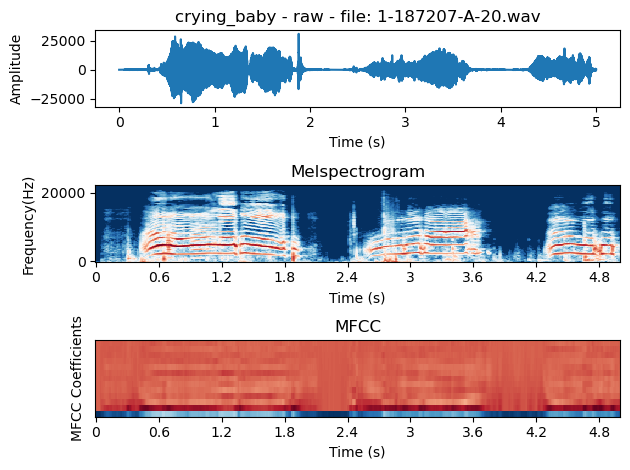

In [123]:
filename = "1-187207-A-20.wav"
plot_example(filename)
IPython.display.Audio("ESC-50/audio/" + filename)

Now, let's plot the amplitude and melspectrogram of one example per category.

In [8]:
def add_subplot_axes(ax, position):
    """
    Originally taken from https://nbviewer.org/github/karoldvl/paper-2015-esc-dataset/blob/
    master/Notebook/ESC-Dataset-for-Environmental-Sound-Classification.ipynb#Setup
    Additional modifications were applied to make it work with Python 3
    """
    box = ax.get_position()
    
    position_display = ax.transAxes.transform(position[0:2])
    position_fig = plt.gcf().transFigure.inverted().transform(position_display)
    x = position_fig[0]
    y = position_fig[1]
    
    return plt.gcf().add_axes([x, y, box.width * position[2], box.height * position[3]])

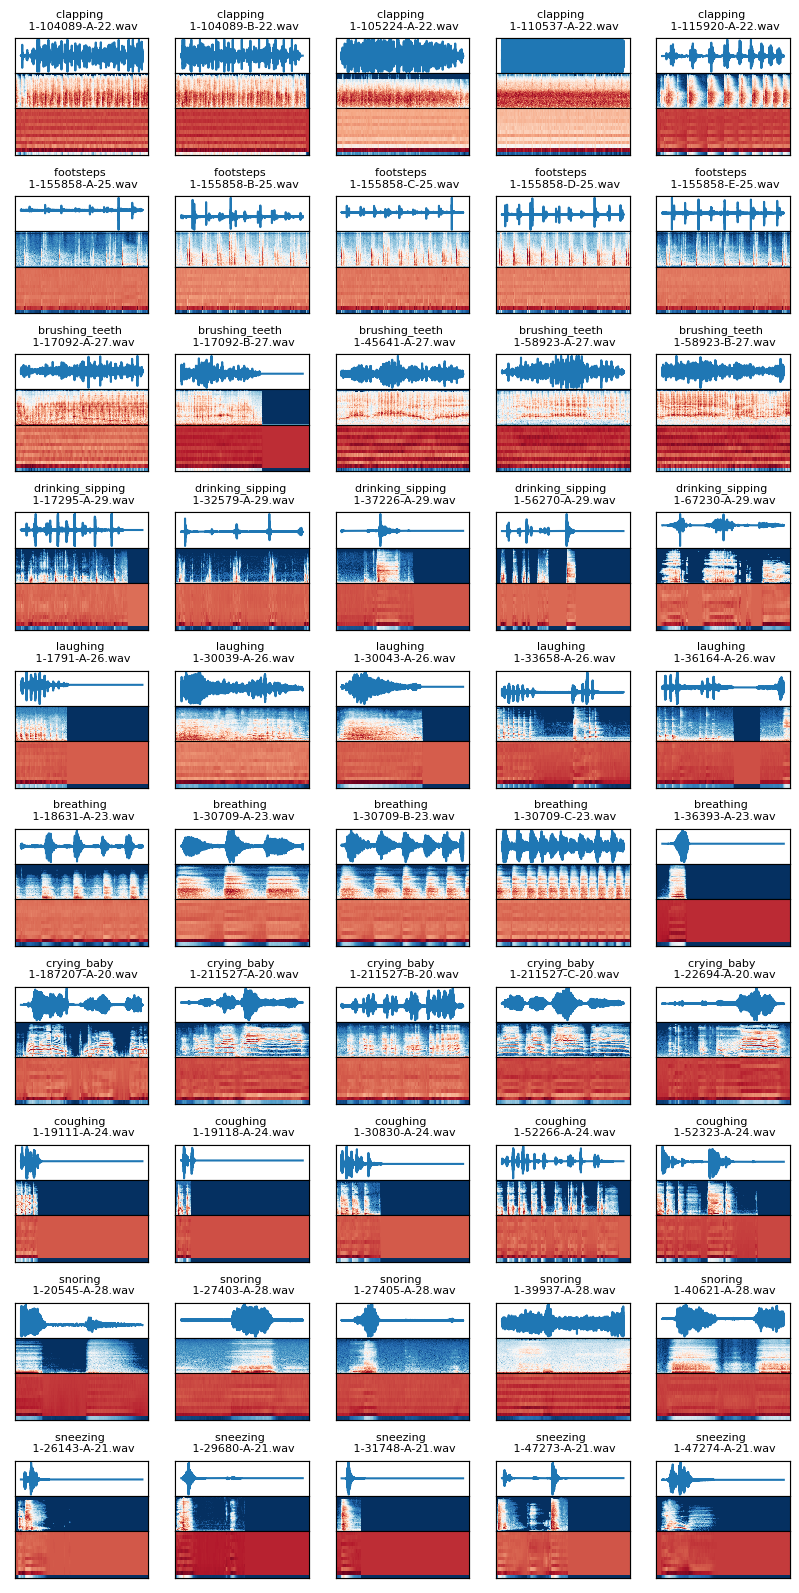

In [9]:
def plot_clip_overview(audio, category, filename ,ax):
    RATE = 44100   # All recordings in ESC are 44.1 kHz
    FRAME = 512    # Frame size in samples
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax_waveform = add_subplot_axes(ax, [0.0, 0.7, 1.0, 0.3]) # [left, bottom, width, height]
    ax_spectrogram = add_subplot_axes(ax, [0.0, 0.4, 1.0, 0.3])
    ax_mfcc = add_subplot_axes(ax, [0.0, 0.0, 1.0, 0.4])
    
    # Extract Raw Audio from Wav File
    signal_raw = audio.readframes(-1)
    signal = np.frombuffer(signal_raw, "int16")
    ax_waveform.plot(np.arange(0, len(signal)) / float(RATE), signal)
    ax_waveform.get_xaxis().set_visible(False)
    ax_waveform.get_yaxis().set_visible(False)
    ax_waveform.set_title('{0} \n {1}'.format(category, filename), {'fontsize': 8}, y=1.03)

    # Compute Melspectrogram Features
    signal = (np.frombuffer(signal_raw, dtype="int16") + 0.5) / (0x7FFF + 0.5) # convert to float
    signal = librosa.feature.melspectrogram(y=signal, sr=RATE, hop_length=FRAME)
    signal = librosa.power_to_db(signal, ref=np.max)
    librosa.display.specshow(signal, x_axis='time', y_axis='linear', sr=RATE, cmap='RdBu_r',ax=ax_spectrogram)
    ax_spectrogram.get_xaxis().set_visible(False)
    ax_spectrogram.get_yaxis().set_visible(False)
    
    # Compute MFCC
    mfcc = librosa.feature.mfcc(S=signal, sr=RATE, n_mfcc=13)
    librosa.display.specshow(mfcc, x_axis='time', sr=RATE, cmap='RdBu_r', ax=ax_mfcc)
    ax_mfcc.get_xaxis().set_visible(False)
    ax_mfcc.get_yaxis().set_visible(False)
    
categories = esc50_human.category.unique()
categories_len = len(categories)
clips_shown = 5
f, axes = plt.subplots(categories_len, clips_shown,
                       figsize=(clips_shown * 2, categories_len * 2), 
                       sharex=True, 
                       sharey=True)
f.subplots_adjust(hspace = 0.35)

for i, c in enumerate(categories):
    for j in range(0, clips_shown):
        filename = esc50_human[esc50_human.category == c].filename.iloc[j]
        spf = wave.open("ESC-50/audio/" + filename, "r")
        plot_clip_overview(spf, c, filename, axes[i, j])

## Creating the MFCC dataset

In this section we will compute the MFCC coefficients for every sample in the `esc50_human` with the purpose of using is as input for machine learning classifiers.

In [10]:
def compute_features(df, is_augmentation=False):
    RATE = 44100   # All recordings in ESC are 44.1 kHz
    FRAME = 512    # Frame size in samples
    dataloader_dict = {}
    for i, row in df.iterrows():  
        filename = row["filename"]
        fold = int(row["fold"])
        target = row["target"]
        category = row["category"]

        spf = wave.open("ESC-50/audio/" + filename, "r")
        signal_raw = spf.readframes(-1)
        
        if is_augmentation:
            
            # draft of this part is at the end!
            
            # TODO: compute different data augmentations here on the raw_signal and then
            # compute the Melspectrogram and MFCC of the augmented data
            # others modifications to the code need to be implemented
            pass
        
        # Compute Melspectrogram Features
        signal = (np.frombuffer(signal_raw, dtype="int16") + 0.5) / (0x7FFF + 0.5) # convert to float
        signal = librosa.feature.melspectrogram(y=signal, sr=RATE, hop_length=FRAME)
        signal = librosa.power_to_db(signal, ref=np.max)
        # Compute MFCC
        mfcc = librosa.feature.mfcc(S=signal, sr=RATE, n_mfcc=13)

        dataloader_dict[i] = {"filename":filename, "data":mfcc, "target":target, "category":category,"fold":fold}
    return dataloader_dict

In [11]:
def train_loader(dic, fold):
    X_val = []
    X_train = []
    y_val = []
    y_train = []

    for id, subj in dic.items():

        if subj["fold"]!=fold:
            X_train.append(subj['data'])
            y_train.append(subj['target'])
                
        if subj["fold"]==fold:
            X_val.append(subj['data'])
            y_val.append(subj['target'])
    
    return np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val)

In [12]:
dataloader_dic = compute_features(esc50_human)
X_train, y_train, X_val, y_val = train_loader(dataloader_dic, fold=1)

`X_train` has a shape of `(320, 13, 431)` meaning that we have 320 examples of shape `(13, 431)` we can think about each example as an image of that size.

## Baseline models
In the following section we will trying some machine learning classifiers (eg: Random Forest, SVM, XGBoost) and then compare those results to much more complex models such a CNN.

In [14]:
# reshape to 2 dimensions, as Random forest does not accept 3D input
nsamples, nx, ny = X_train.shape
X_train_2d = X_train.reshape((nsamples,nx*ny))

nsamples, nx, ny = X_val.shape
X_val_2d = X_val.reshape((nsamples,nx*ny))

In [15]:
def eval_and_plot(model, X_val, y_true, labels):
    y_pred = model.predict(X_val)
    model_acc = accuracy_score(y_true, y_pred)
    conf_mat = confusion_matrix(y_true, y_pred)
    
    ax = sns.heatmap(conf_mat, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)
    ax.set(xlabel="Predicted Category", ylabel="True Category")
    
    return model_acc

In [16]:
plot_labels = ['crying_baby', 'sneezing', 'clapping', 
              'breathing', 'coughing', 'footsteps', 
              'laughing', 'brushing_teeth', 'snoring', 
              'drinking_sipping']

### Random Forrest Classifier

In [12]:
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth':[5, 10, 15]
}

rand_forest = RandomForestClassifier(random_state=0)
clf = GridSearchCV(rand_forest, param_grid, cv = 5)
clf.fit(X_train_2d, y_train)

Validation Accuracy of a Random Forest Classifier 0.4875


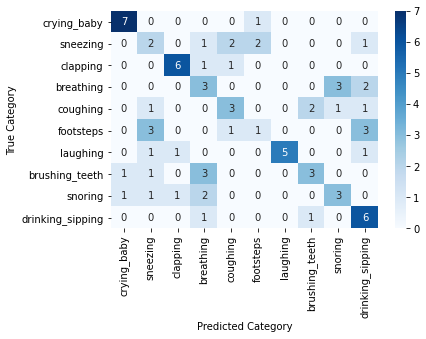

In [18]:
forest_acc = eval_and_plot(clf, X_val_2d, y_val, plot_labels)
print("Validation Accuracy of a Random Forest Classifier", forest_acc)

### SVM

Validation Accuracy of an SVM 0.3875


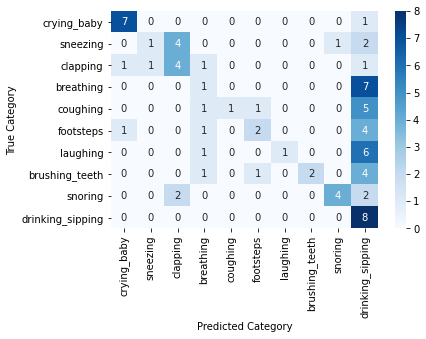

In [19]:
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
  
svm_grid = GridSearchCV(svm.SVC(random_state = 0), param_grid)
  
# fitting the model for grid search
svm_grid.fit(X_train_2d, y_train)

svm_acc = eval_and_plot(svm_grid, X_val_2d, y_val, plot_labels)
print("Validation Accuracy of an SVM", svm_acc)

### XGBoost

In [20]:
y_train_0 = y_train-20
y_val_0 = y_val-20

C:\Users\ivan_\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:24:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:25:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:25:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:26:21] WARNI

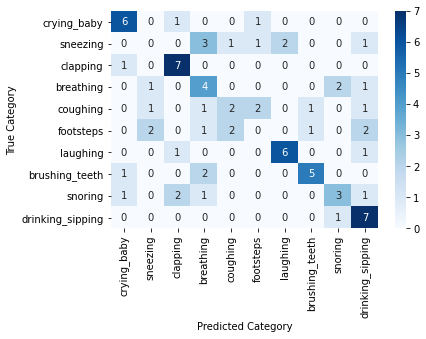

In [22]:
param_grid = {
    'max_depth': [5, 10, 15]
}

boost = xgb.XGBClassifier(random_state=0)

xgb_grid = GridSearchCV(boost, param_grid)

xgb_grid.fit(X_train_2d, y_train)

xgb_acc = eval_and_plot(xgb_grid, X_val_2d, y_val, plot_labels)
print("Validation Accuracy of an SVM", xgb_acc)

We additionally create a dataset containing augmented version of the raw input data. Following the augmentation techniques, the MFCC dataset is compiled for the larger sample and our model are ran on it. 

## Data Preparation for NN

In [147]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio.transforms as transforms
import torchaudio
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random
from torchaudio_augmentations import Compose, ComposeMany, Noise, Gain, PolarityInversion, Delay, HighLowPass, RandomApply

# Avoiding nondeterministic algorithms for reproducibility purposes
torch.use_deterministic_algorithms(True)
random.seed(0)
np.random.seed(0)

In [8]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(42)
torch.manual_seed(42)

In [9]:
def get_dataloader_dict(df):
    dataloader_dict = {}
    for i, row in df.iterrows():  
        filename = row["filename"]
        fold = int(row["fold"])
        target = row["target"]
        category = row["category"]
        
        waveform, sample_rate = torchaudio.load("ESC-50/audio/" + filename, normalize=True)
        dataloader_dict[i] = {"filename":filename, "data":waveform, "target":target, "category":category,"fold":fold}
    return dataloader_dict

In [10]:
def train_val_loader(dic, fold):
    X_val = []
    X_train = []
    y_val = []
    y_train = []

    for id, subj in dic.items():

        if subj["fold"]!=fold:
            X_train.append(subj['data'])
            y_train.append(subj['target'])
                
        if subj["fold"]==fold:
            X_val.append(subj['data'])
            y_val.append(subj['target'])
    
    return X_train, np.array(y_train), X_val, np.array(y_val)

In [11]:
class ESCHDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        
        if self.transform:
            x = self.transform(x)        
        return x, y
    
    def __len__(self):
        return len(self.data)

## Training Functions

In [12]:
# Function to save the model - best model in terms of validation accuracy
def save_model(model, model_name): 
    path = f"./models/{model_name}_.pth" 
    torch.save(model.state_dict(), path)

In [13]:
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
    if hasattr(layer, 'reset_parameters'):
        # print(f'Reset trainable parameters of layer = {layer}')
        layer.reset_parameters()

In [203]:
# Class oringinally taken from https://stackoverflow.com/a/73704579
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [259]:
def train(num_epochs, training_loader, validation_loader, model, model_name_fold, is_augmented):
    best_accuracy_value = 0.0
    train_loss_list = []
    val_loss_list = []
    early_stopper = EarlyStopper(patience=10, min_delta=0.1)

    
    print("Begin Training")
    for epoch in range(num_epochs):
        running_train_loss = 0.0
        running_train_accuracy = 0.0
        running_val_loss = 0.0
        running_val_accuracy = 0.0
        total = 0

        # training loop
        model.train()
        for i, data in enumerate(training_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            if is_augmented == True:
                inputs = torch.flatten(inputs, start_dim=0, end_dim=1)
                labels = labels.repeat(5)
            labels = labels.to(torch.long)
            inputs = inputs.to(torch.float32)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            train_loss = criterion(outputs, labels)
            train_loss.backward()
            optimizer.step()

            # track train loss
            running_train_loss += train_loss.item()
            # make predictions on training data
            _, train_preds = torch.max(outputs, 1)
            # track train f1-score
            running_train_accuracy += accuracy_score(labels, train_preds)

        # calculate train loss and train accuracy values
        train_loss_value = running_train_loss / len(training_loader)
        train_accuracy_value = running_train_accuracy / len(training_loader)

        # validation loop
        model.eval()
        with torch.no_grad():
            for data in validation_loader:
                inputs, labels = data
                labels = labels.to(torch.long)
                outputs = model(inputs)
                val_loss = criterion(outputs, labels)

                _, val_preds = torch.max(outputs, 1)
                running_val_loss += val_loss.item()
                total += outputs.size(0)
                running_val_accuracy += accuracy_score(labels, val_preds) 
        
        # calculate val loss and val f1-score values
        val_loss_value = running_val_loss / len(validation_loader)
        val_accuracy_value = running_val_accuracy / len(validation_loader)
        
        # call lr scheduler
        scheduler.step(val_loss_value)
        print(f"Current lr:{scheduler.optimizer.param_groups[0]['lr']}")

        # Save model is val f1-score is the best
        if val_accuracy_value > best_accuracy_value:
            save_model(model, model_name_fold)
            best_accuracy_value = val_accuracy_value

        # Print the statistics of the epoch 
        train_loss_list.append(train_loss_value)
        val_loss_list.append(val_loss_value)
        
        # print(f'Current lr: {optimizer.param_groups[0]["lr"]}')
        print('Completed training batch', epoch, 'Train Loss: %.4f' %train_loss_value, 
              'Val Loss: %.4f' %val_loss_value, 'Train Accuracy: %.4f' %train_accuracy_value, 
              'Val Accuracy: %.4f' %val_accuracy_value)
        
        # stop if val loss has no t decreased in the last (# of patience) epochs
        if early_stopper.early_stop(val_loss_value):
            print("Early Stopping")
            break

    print('Finished Training')
    
    # plot loss for training and validation for the current batch
    plt.plot(train_loss_list[0:-1])
    plt.plot(val_loss_list[0:-1])
    plt.show()
    
    # pass back the accuracy from the best model
    return train_loss_list, val_loss_list, best_accuracy_value

In [260]:
# function for cross-validation
def train_cv(num_epochs, df, model, model_name, transformations, is_augmented=False, n_folds=5):
    '''
    Inputs required/define:
    - number of training epochs (num_epochs) per fold
    - df is input data
    - n_folds - use 5-fold cross-validation
    - model is the defined model we use for training and validation
    - model_name asks for how to save the model
    - transformations is a torch.Compose object computing MFCCs / or also augmentations
    '''
    # to store loss and accuracy of each fold
    train_losses = {}
    val_losses = {}
    batch_times = []
    accuracies = []
    
    # open data
    dataloader_dic = get_dataloader_dict(df)
    
    for i in range(1, n_folds+1):
        # reset model weights to avoid weights leakage between folds
        model.apply(reset_weights)
        
        print(f'FOLD # {i}')
        model_name_fold = str(model_name) + '_fold_' + str(i)
        training_start_time = time.time()
        
        X_train, y_train, X_val, y_val = train_val_loader(dataloader_dic, fold=i)
        
        train_dataset = ESCHDataset(X_train, y_train, transform=transformations)
        train_loader = DataLoader(train_dataset, batch_size=80, drop_last=True,
                                 worker_init_fn=seed_worker, 
                                 generator=g)
        val_dataset = ESCHDataset(X_val, y_val, transform=transform_mfcc)
        val_loader = DataLoader(val_dataset, batch_size=80, drop_last=True,
                                 worker_init_fn=seed_worker, 
                                 generator=g)
        
        # train for current fold of data
        # train(num_epochs, training_loader, validation_loader, model, model_name_fold)
        train_loss_fold, val_loss_fold, best_accuracy = train(num_epochs, 
                                                              train_loader, 
                                                              val_loader, 
                                                              model, 
                                                              model_name_fold,
                                                              is_augmented)
        
        # stop time and print total fold runtime 
        training_stop_time = time.time()
        batch_runtime = training_stop_time - training_start_time
        batch_times.append(batch_runtime)
        
        print(f'Fold {i} runtime: {batch_runtime}')
        
        # plot loss for training and validation
        #plt.plot(train_loss_fold[0:-1])
        #plt.plot(val_loss_fold[0:-1])
        
        # save loss and acc in dictionary for later prediction and comparison
        train_losses[i] = train_loss_fold
        val_losses[i] = val_loss_fold
        
        # at the end of every fold, appemd the best accuracy 
        accuracies.append(best_accuracy)
      

    mean_acc = sum(accuracies)/len(accuracies) # and then return the average over the best models for each fold
    
    return train_losses, val_losses, batch_times, mean_acc

## Simple CNN

In [261]:
class CNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(4, 4), stride=1)
        self.bn1 = nn.BatchNorm2d(1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(in_features=1070, out_features=420)
        self.fc2 = nn.Linear(in_features=420, out_features=10)
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        #x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        #x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [291]:
class BIGCNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1)
        self.conv6 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool1 = nn.AvgPool2d(1, stride=2)
        self.fc1 = nn.Linear(in_features=6720, out_features=1080)
        self.fc2 = nn.Linear(in_features=1080, out_features=10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn2(self.conv3(x)))
        x = F.relu(self.bn3(self.conv4(x)))
        x = F.relu(self.bn2(self.conv5(x)))
        x = F.relu(self.bn2(self.conv6(x)))
        x = self.pool1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

### Simple CNN - Without Data Augmentation

In [ ]:
RATE = 44100
transform_mfcc = transforms.MFCC(sample_rate=RATE, 
                     n_mfcc=13,
                     melkwargs={"n_fft": 2048, "hop_length": 512, "n_mels": 60})
net = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# the train_cv function needs (num_epochs, df, model, model_name, transformations, n_folds = 5)
name = 'CNN_MFCC_baseline_run3'
train_loss_dict, val_loss_dict, batch_runtimes, mean_accuracy = train_cv(100, esc50_human, net, name, transform_mfcc)

In [ ]:
# show mean validation accuracy over all folds and best epochs
print(f"Mean runtime per fold (s): {np.round(np.mean(batch_runtimes))}")
print(f"Mean val accuracy: {np.round(mean_accuracy, 2)}")

### Simple CNN - With Data Augmentation

#### Original signal

In [139]:
RATE = 44100

filename = "1-187207-A-20.wav"
audio = torchaudio.load("ESC-50/audio/" + filename, normalize=True)[0]
IPython.display.Audio(audio, rate=RATE)

#### Noise

In [140]:
taudio = Noise(min_snr=0.01, max_snr=0.05)(audio)
IPython.display.Audio(taudio, rate=RATE)

#### Delay

In [141]:
taudio = Delay(sample_rate=RATE, min_delay=50, max_delay=55)(audio)
IPython.display.Audio(taudio, rate=RATE)

#### HighLowPass

In [144]:
taudio = HighLowPass(sample_rate=RATE)(audio)
IPython.display.Audio(taudio, rate=RATE)

#### All at the same time

In [145]:
taudio = Noise(min_snr=0.01, max_snr=0.05)(audio)
taudio = Delay(sample_rate=RATE, min_delay=50, max_delay=55)(taudio)
taudio = HighLowPass(sample_rate=RATE)(taudio)
IPython.display.Audio(taudio, rate=RATE)

In [ ]:
transform = ComposeMany(
    [
        RandomApply([Noise(min_snr=0.01, max_snr=0.05)], p=0.5),
        RandomApply([HighLowPass(sample_rate=RATE)], p=0.5),
        RandomApply([Delay(sample_rate=RATE, min_delay=50, max_delay=55)], p=0.5),
        transforms.MFCC(sample_rate=RATE, 
                     n_mfcc=13, 
                     melkwargs={"n_fft": 2048, "hop_length": 512, "n_mels": 60})
    ], num_augmented_samples=5)

net = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min')
# the train_cv function needs (num_epochs, df, model, model_name, transformations, n_folds = 5)
name = 'CNN_MFCC_augmented_run1'
train_loss_dict, val_loss_dict, batch_runtimes, mean_accuracy = train_cv(100, 
                                                                         esc50_human, 
                                                                         net,
                                                                         name, 
                                                                         transform, 
                                                                         is_augmented=True)

In [ ]:
# show mean validation accuracy over all folds and best epochs
print(f"Mean runtime per fold (s): {np.round(np.mean(batch_runtimes))}")
print(f"Mean val accuracy: {np.round(mean_accuracy, 2)}")

## Old code + alternative CNN architecture [DELETE LATER]

In [117]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(42)

class CNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(4, 4), stride=1)
        self.bn1 = nn.BatchNorm2d(1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(in_features=1070, out_features=420)
        self.fc2 = nn.Linear(in_features=420, out_features=10)
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x
    
# more complex CNN
class CNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.dropout = nn.Dropout(0.5)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=(3, 3), stride=1)
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3, 3), stride=1)
        self.bn1 = nn.BatchNorm2d(3)
        self.bn2 = nn.BatchNorm2d(6)
        self.conv3 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=(2, 2), stride=1)
        self.conv4 = nn.Conv2d(in_channels=6, out_channels=6, kernel_size=(2, 2), stride=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(in_features=630, out_features=240)
        self.fc2 = nn.Linear(in_features=240, out_features=10)
    

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.bn1(self.conv2(x))))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.conv3(x)))
        x = self.pool(F.relu(self.bn2(self.conv4(x))))
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

### Testing architectures [DELETE LATER]

In [272]:
iteritems_train = iter(train_loader)
data, labels = next(iteritems_train)

In [603]:
net.eval()
outputs = net(X_train)
_, train_preds = torch.max(outputs, 1)
print(f"train preds: {train_preds}")
print(f"train labels: {y_train}")
print(f"accuracy: {accuracy_score(y_train, train_preds)}")

train preds: tensor([0, 0, 0, 0, 0, 0, 0, 1, 9, 1, 1, 1, 9, 2, 2, 3, 4, 5, 6, 7, 7, 8, 6, 5,
        6, 7, 6, 6, 9, 8, 8, 9, 0, 4, 5, 5, 5, 7, 9, 3, 4, 3, 5, 9, 9, 9, 7, 9,
        2, 6, 2, 2, 9, 9, 8, 1, 7, 7, 8, 7, 9, 3, 7, 2])
train labels: tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 3, 4, 5, 6, 7, 7, 8, 6, 6,
        6, 1, 6, 6, 9, 8, 8, 9, 4, 4, 5, 5, 5, 7, 9, 3, 4, 4, 4, 5, 5, 5, 5, 3,
        8, 8, 8, 2, 9, 9, 8, 1, 7, 7, 8, 7, 9, 3, 7, 2])
accuracy: 0.765625


In [604]:
net.eval()
outputs = net(X_val)
_, val_preds = torch.max(outputs, 1)
print(f"val preds: {val_preds}")
print(f"val labels: {y_val}")
print(f"accuracy: {accuracy_score(y_val, val_preds)}")

val preds: tensor([9, 7, 2, 6, 7, 7, 4, 5, 8, 8, 7, 5, 2, 7, 9, 5, 3, 8, 0, 4, 9, 9, 9, 5,
        5, 0, 5, 0, 0, 1, 8, 1, 0, 4, 4, 4, 5, 5, 8, 4, 4, 4, 0, 0, 7, 0, 4, 7,
        8, 8, 2, 8, 8, 8, 8, 0, 4, 8, 9, 8, 5, 9, 2, 8, 7, 2, 8, 9, 4, 4, 4, 2,
        7, 9, 2, 8, 5, 8, 4, 7])
val labels: tensor([3, 3, 6, 6, 7, 9, 4, 4, 8, 8, 8, 8, 8, 9, 9, 3, 3, 3, 7, 3, 9, 9, 9, 6,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 6, 6, 5, 8, 8, 5, 5, 0, 4, 4, 4, 0, 4, 5,
        6, 6, 2, 0, 0, 0, 0, 4, 4, 8, 6, 2, 5, 9, 2, 5, 7, 2, 2, 7, 7, 7, 7, 2,
        3, 9, 2, 3, 5, 2, 5, 7])
accuracy: 0.375


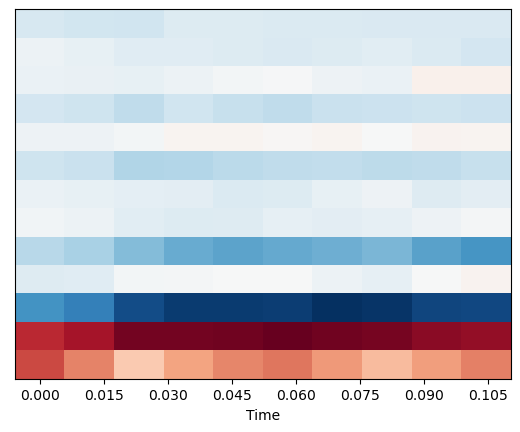

In [671]:
librosa.display.specshow(data[2, 0, :, :10].numpy(), x_axis='time', sr=RATE, cmap='RdBu_r')

In [265]:
conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(4, 4), stride=1)
pool1 = nn.MaxPool2d(2, 2)
fc1 = nn.Linear(in_features=1070, out_features=420)
fc2 = nn.Linear(in_features=420, out_features=10)

print(data.shape)
x = pool1(F.relu(bn1(conv1(data))))
print(x.shape)
print(x.shape)
x = torch.flatten(x, 1)
print(x.shape)
x = F.relu(fc1(x))
print(x.shape)
x = fc2(x)
print(x.shape)

torch.Size([80, 4, 1, 13, 431])


NameError: name 'bn1' is not defined

In [290]:
conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1)
conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1)
conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1)
conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1)
conv5 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1)
conv6 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1)
bn1 = nn.BatchNorm2d(16)
bn2 = nn.BatchNorm2d(32)
bn3 = nn.BatchNorm2d(64)
pool1 = nn.MaxPool2d(2, 2)
pool1 = nn.AvgPool2d(1, stride=2)
fc1 = nn.Linear(in_features=6720, out_features=1080)
fc2 = nn.Linear(in_features=1080, out_features=10)

x = torch.flatten(data, start_dim=0, end_dim=1)
print(x.shape)
x = F.relu(bn1(conv1(x)))
print(x.shape)
x = F.relu(bn2(conv2(x)))
print(x.shape)
x = F.relu(bn2(conv3(x)))
print(x.shape)
x = F.relu(bn3(conv4(x)))
print(x.shape)
x = F.relu(bn2(conv5(x)))
print(x.shape)
x = F.relu(bn2(conv6(x)))
print(x.shape)
x = pool1(x)
print(x.shape)
x = torch.flatten(x, 1)
print(x.shape)
x = F.relu(fc1(x))
print(x.shape)
x = fc2(x)
print(x.shape)

torch.Size([320, 1, 13, 431])
torch.Size([320, 16, 11, 429])
torch.Size([320, 32, 9, 427])
torch.Size([320, 32, 7, 425])
torch.Size([320, 64, 5, 423])
torch.Size([320, 32, 3, 421])
torch.Size([320, 32, 1, 419])
torch.Size([320, 32, 1, 210])
torch.Size([320, 6720])
torch.Size([320, 1080])
torch.Size([320, 10])


In [ ]:
model =  models.Sequential([
                          layers.Conv2D(16 , (3,3),activation = 'relu',padding='valid', input_shape = INPUTSHAPE),
                          layers.Conv2D(16, (3,3), activation='relu',padding='valid'),

                          layers.Conv2D(32, (3,3), activation='relu',padding='valid'),
                          layers.Conv2D(32, (3,3), activation='relu',padding='valid'),

                          layers.Conv2D(64, (3,3), activation='relu',padding='valid'),
                          layers.Conv2D(32, (3,3), activation='relu',padding='valid'),
                          layers.GlobalAveragePooling2D(),


                          layers.Dense(32 , activation = 'relu'),
                          layers.Dense(10 , activation = 'softmax')
])

In [ ]:
class CNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1)
        self.conv6 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1)        
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(in_features=1070, out_features=420)
        self.fc2 = nn.Linear(in_features=420, out_features=10)
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        #x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        #x = self.dropout2(x)
        x = self.fc2(x)
        return x